In [1]:
import os
import sys
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

prj_dir = os.path.abspath(os.getcwd() + '/..')
print(prj_dir)
sys.path.append(prj_dir)

/Users/raul.sanchez/data_scientia/rulo_mota_omath


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import train_test_split

from src import config
from src.features import X_features
from src.features import banxico_mun_income_remittances

In [3]:
path = os.path.join(
    config.PRJ_DIR,
    'data/processed/X.csv')

data = pd.read_csv(path)
data.set_index('id', inplace=True)

remittances_raw = banxico_mun_income_remittances.get()

In [4]:
# lower_bound, upper_bound = remittances_raw['Remittance Amount Million USD'].quantile([.05, .95]).tolist()

remittances = remittances_raw
# [(
#     remittances_raw['Remittance Amount Million USD'] > lower_bound
# ) & (
#     remittances_raw['Remittance Amount Million USD'] < upper_bound
# )]

In [5]:
# data['Remittance Amount Million USD'] = remittances_raw['Remittance Amount Million USD']

divide by zero encountered in log1p
invalid value encountered in log1p


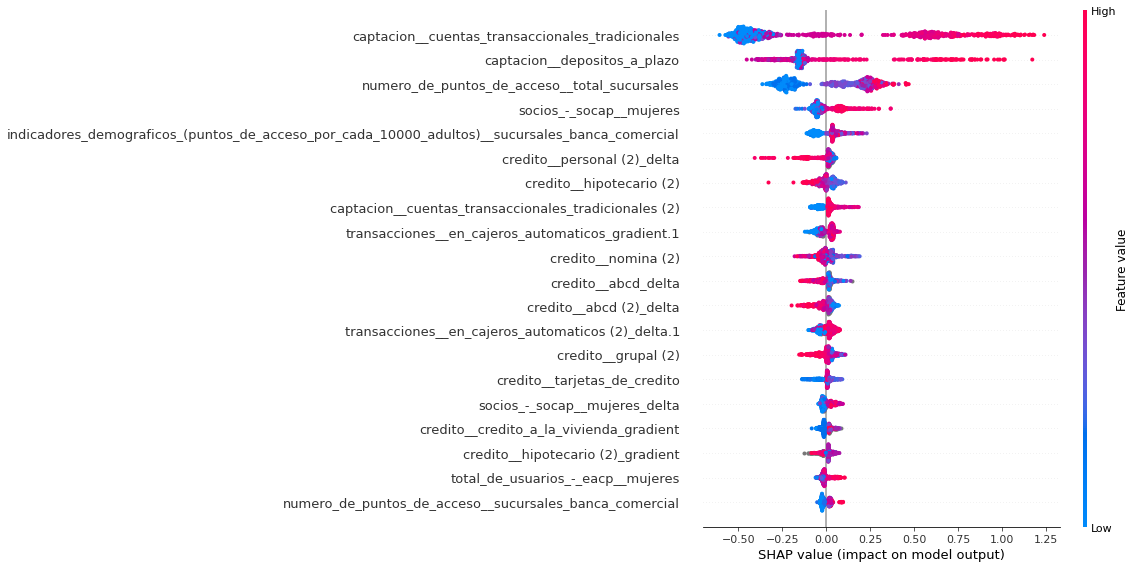

divide by zero encountered in log1p
invalid value encountered in log1p


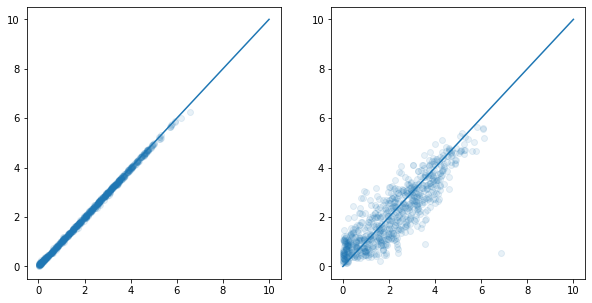

invalid value encountered in subtract
invalid value encountered in true_divide


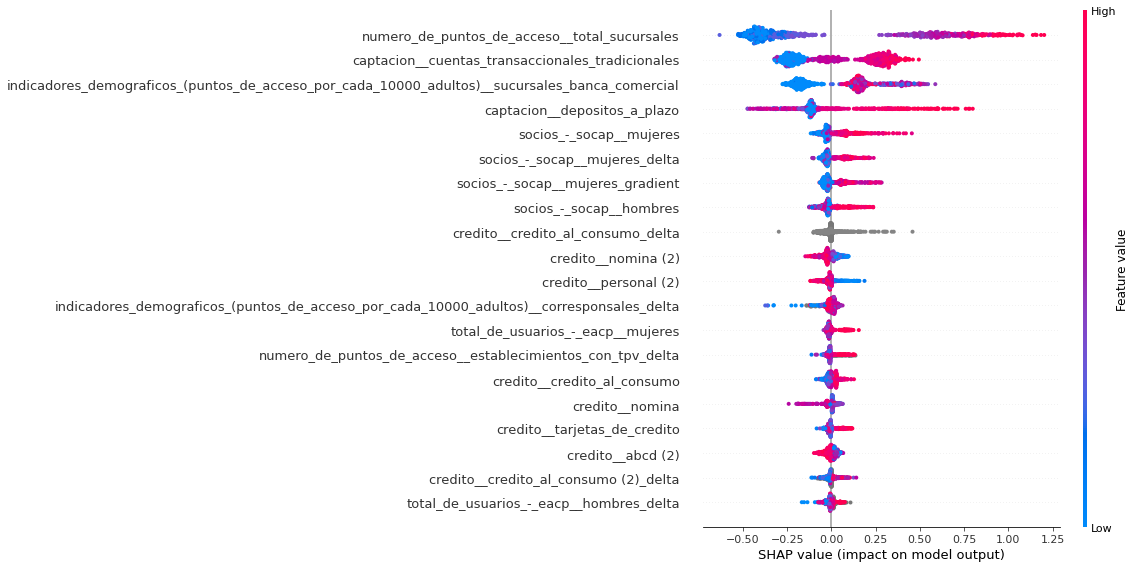

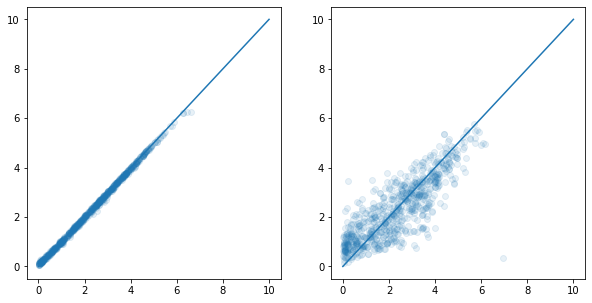

In [21]:
feature_importance, shap_cache = {}, {}
for year, year_data in data.groupby('year'):
    X = year_data.drop(['year', 'mun', 'year.1','year.2', 'mun.1', 'mun.2'], axis=1)
    X = X.apply(lambda x: np.log1p(x))
    
    year_remittances = remittances[remittances['Year'] == year]
    y = year_remittances['Remittance Amount Million USD'].apply(lambda x: np.log1p(x))
    
    valid_ids = list(set(X.index).intersection(year_remittances.index))
    
    X, y = X.loc[valid_ids], y.loc[valid_ids]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        train_size=.5,
        random_state=1)
    
    model = XGBRegressor(
        learning_rate=0.01, 
        max_depth=8, 
        n_estimators=1000)

    model.fit(
        X_train, y_train,
        eval_set=[
            (X_train, y_train),
            (X_test, y_test)
        ],
        early_stopping_rounds=10,
        verbose=False)
    
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(
        X_test, 
        check_additivity=False)
    
    features_shap_values = pd.DataFrame(
        shap_values,
        columns=X_test.columns)
    
    features_shap_values_contribution = features_shap_values.abs().sum()
    
    feature_importance[year] = features_shap_values_contribution

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    shap.summary_plot(
        shap_values, 
        X_test, 
        max_display=20)
    
    shap_cache[year] = {
        'X': X_test, 
        'shap_values': shap_values, 
        'f_shap_values': features_shap_values}
    
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    for it, (y_true, y_pred) in enumerate(zip([y_train, y_test], [y_pred_train, y_pred_test])):        
        ax[it].scatter(
            y_true.values,
            y_pred,
            alpha=.1)
        ax[it].plot([0, 10], [0, 10])
    
year_importance = pd.DataFrame(feature_importance).T
year_importance_norm = (year_importance.T / year_importance.T.sum()).T

In [22]:
year_importance_stats = pd.DataFrame({
    'mean': year_importance_norm.mean().sort_values(),
    'std': year_importance_norm.std().sort_values(),
    'max': year_importance_norm.max().sort_values()
})

In [23]:
# is_shap_always_greater_than_1 = (year_importance_norm < 0.0001).sum() == 0

# feature_selection = year_importance_stats[(
#     is_shap_always_greater_than_1
# ) & (
#     year_importance_stats['mean'] >= year_importance_stats['mean'].quantile(.5)
# )].sort_values('std').index

In [24]:
top_n = 30
feature_selection = year_importance_stats['max'].sort_values().iloc[-top_n:].index

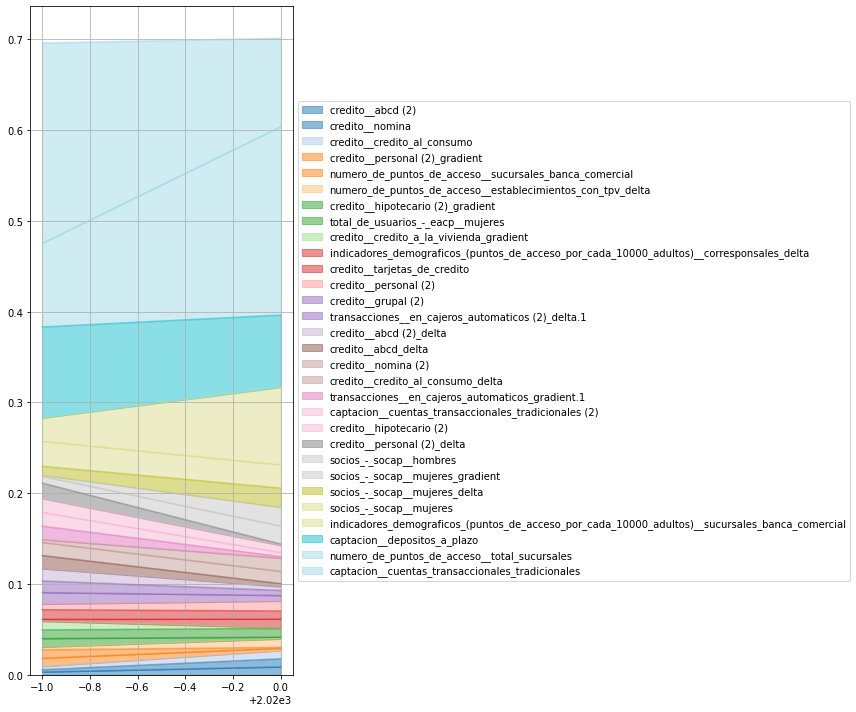

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
year_importance_norm[feature_selection].plot(
    kind='area',
    alpha=.5,
    grid=True,
    stacked=True,
    ax=ax,
    cmap='tab20')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_tight_layout('tight')

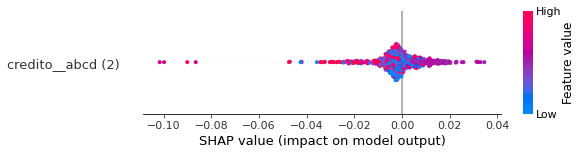

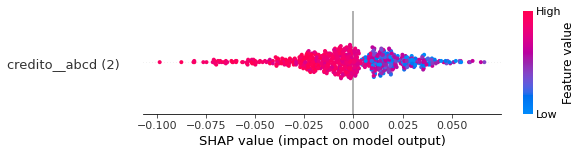

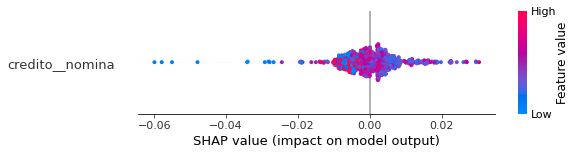

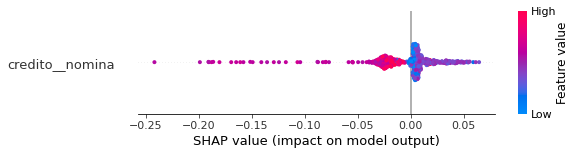

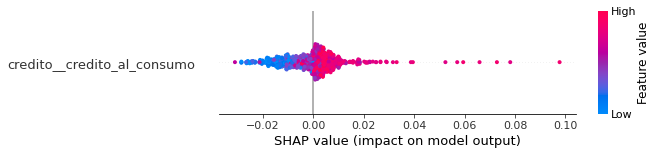

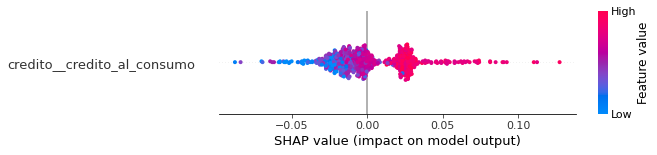

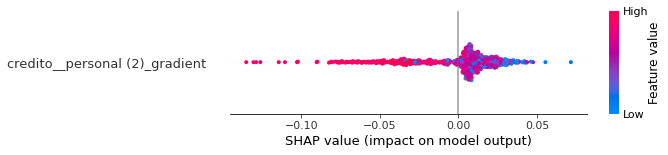

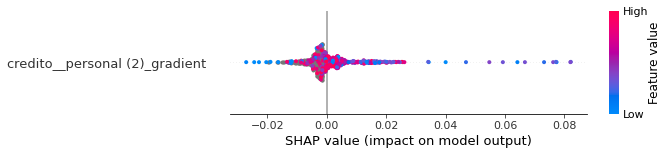

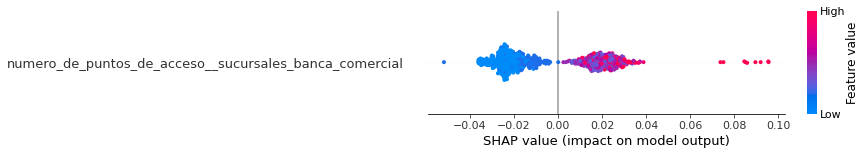

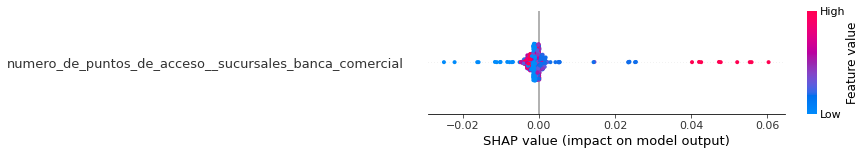

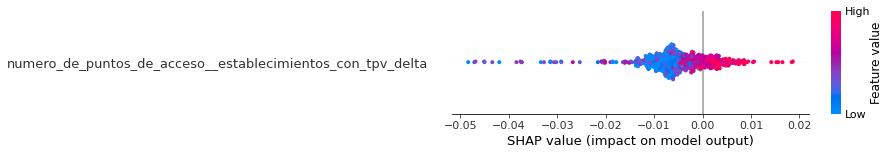

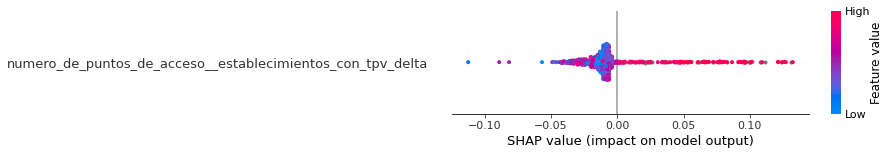

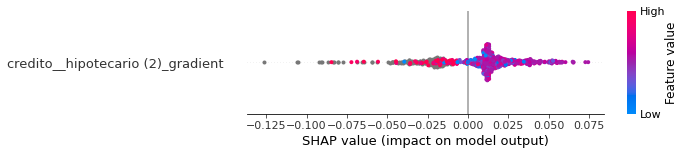

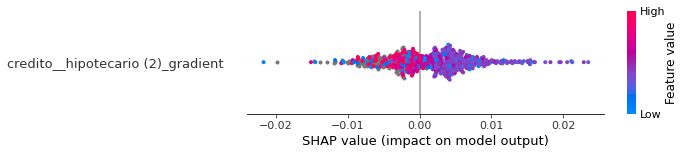

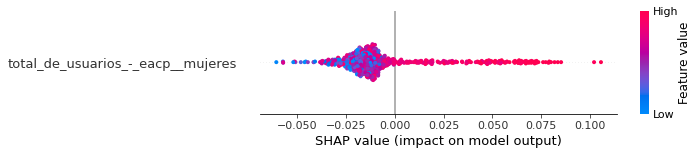

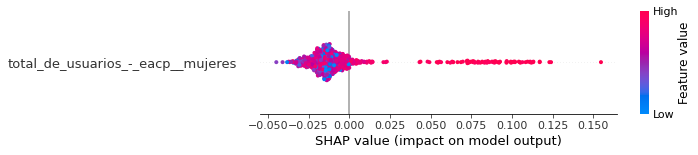

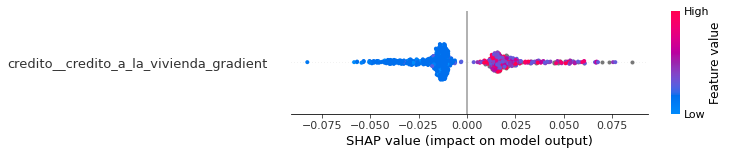

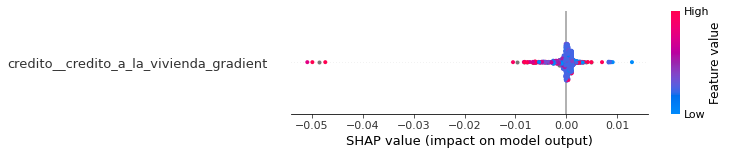

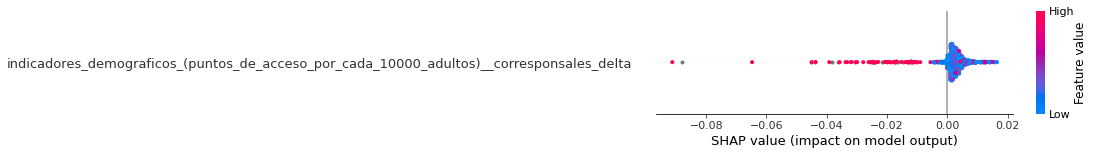

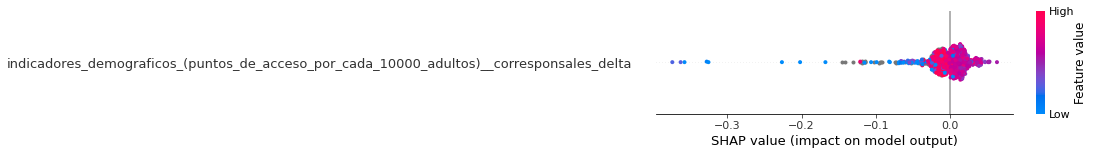

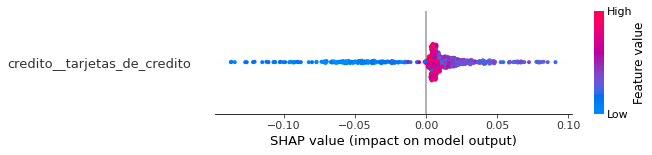

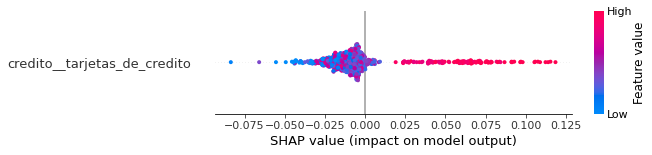

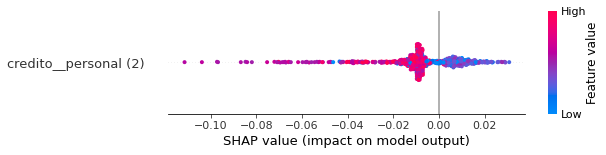

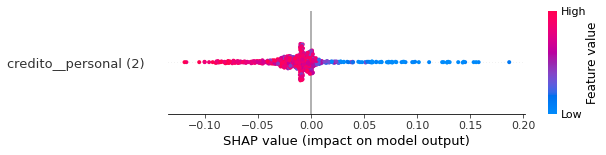

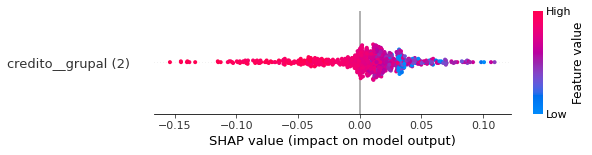

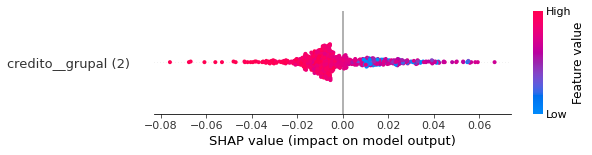

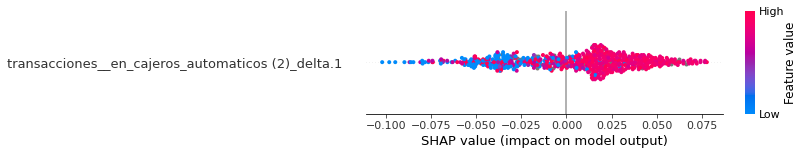

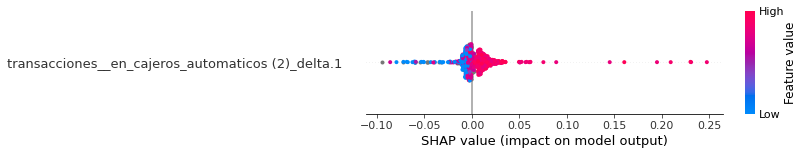

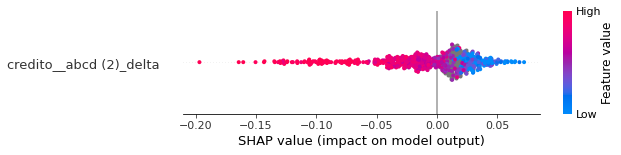

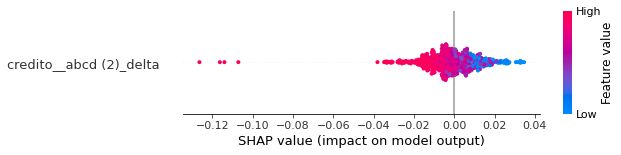

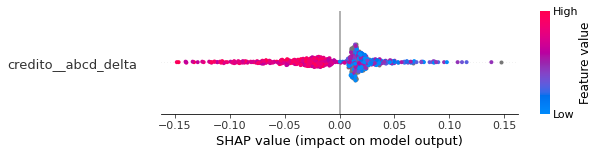

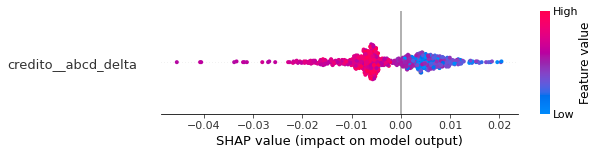

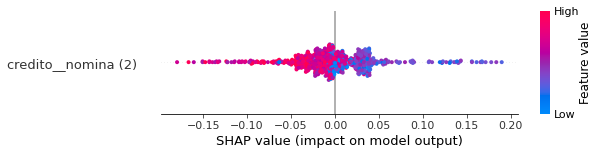

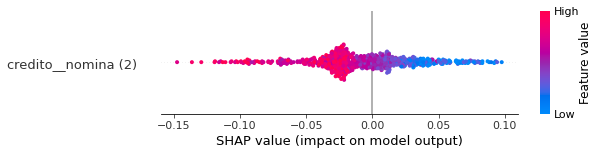

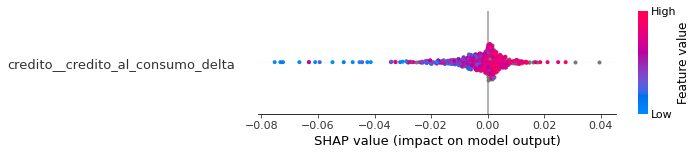

invalid value encountered in subtract
invalid value encountered in true_divide


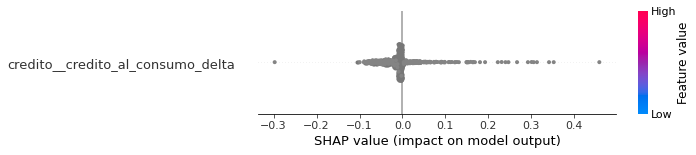

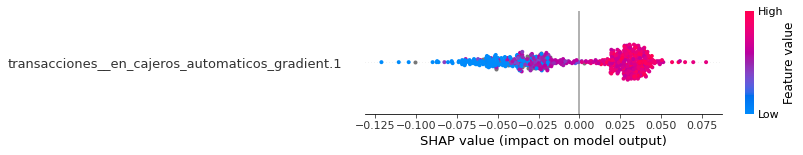

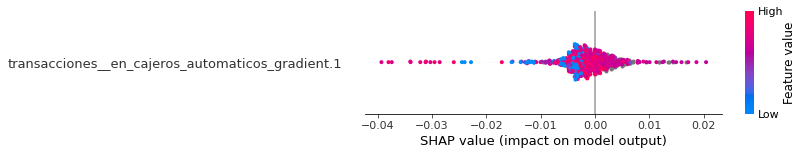

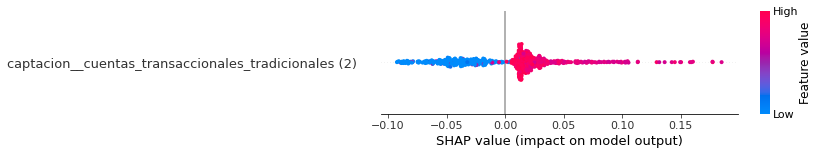

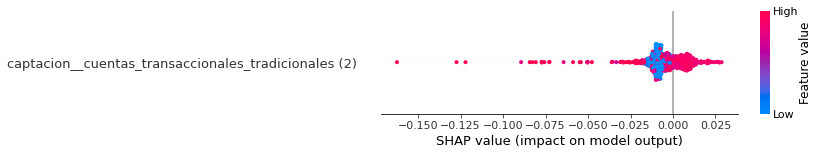

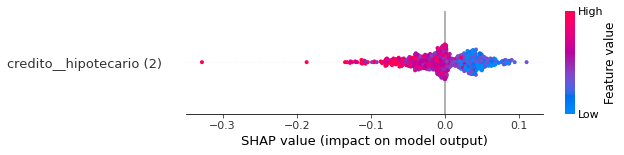

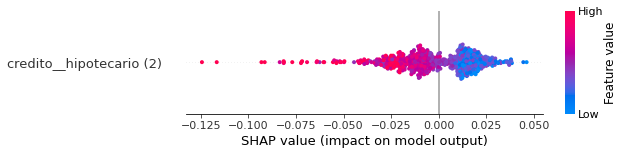

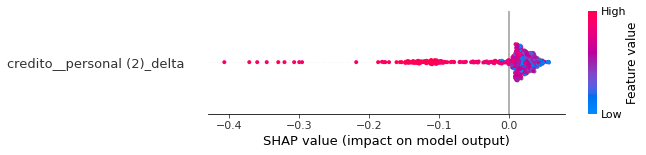

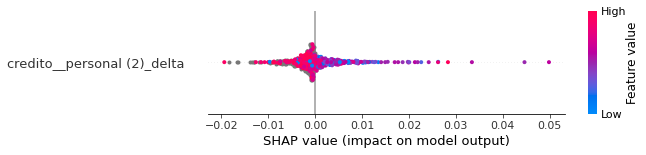

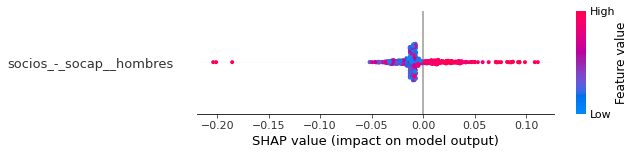

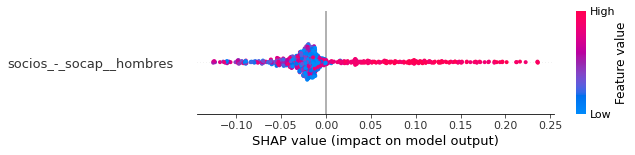

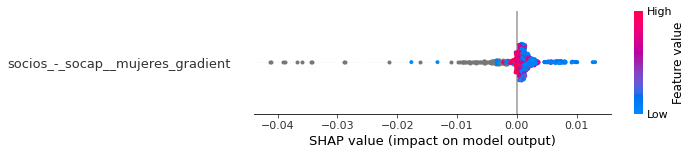

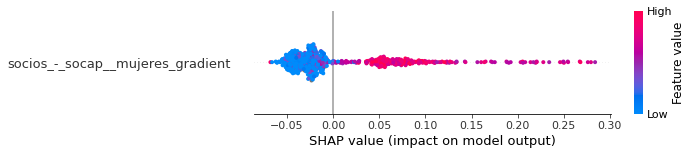

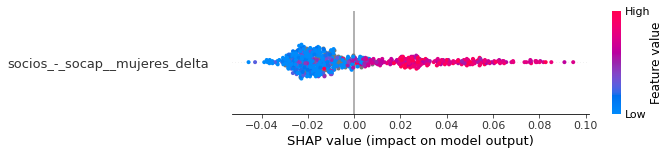

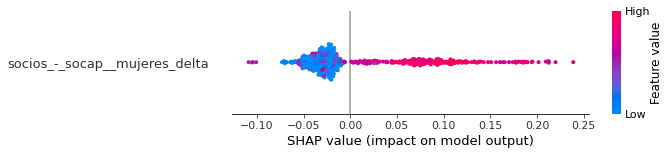

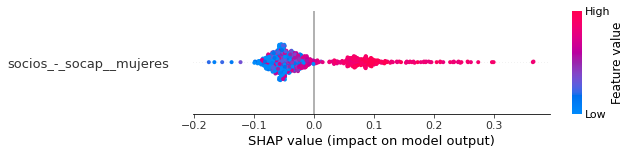

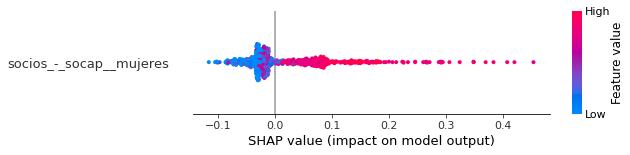

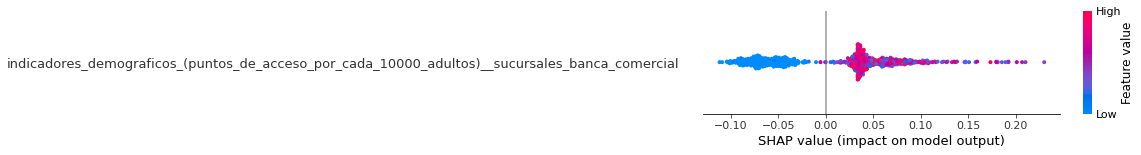

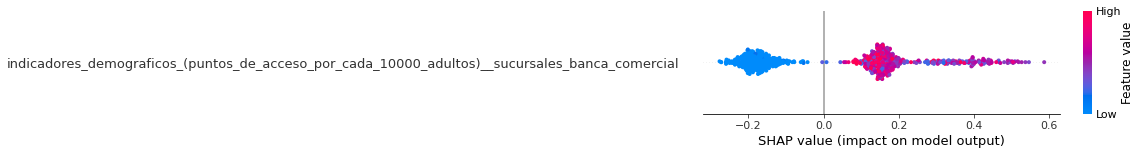

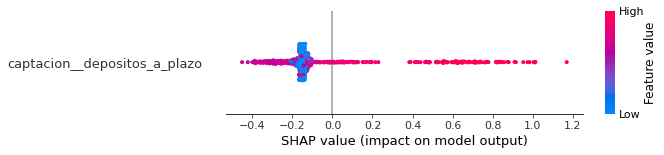

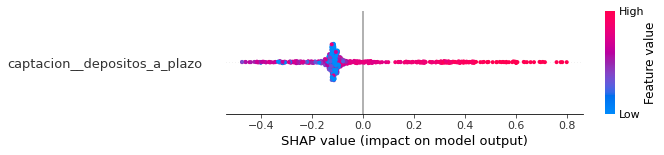

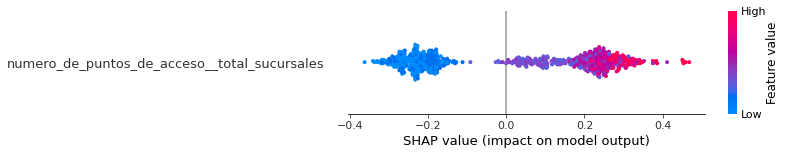

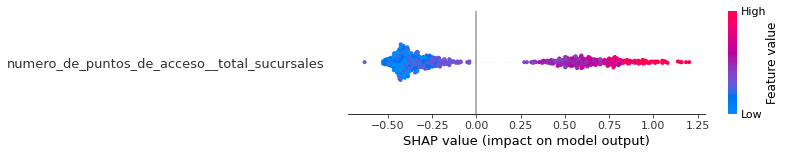

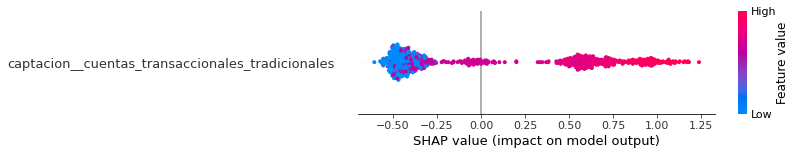

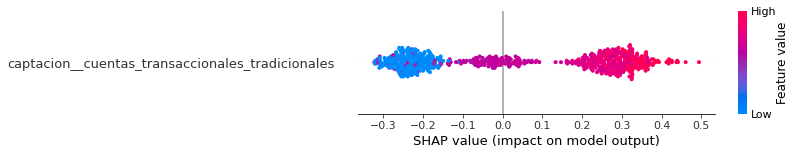

In [26]:
for f in feature_selection:
    for year, year_shap in shap_cache.items():
        shap.summary_plot(
            year_shap['f_shap_values'][[f]].values, 
            year_shap['X'][[f]])